# Assignment 10: Review

We will review material covered so far in this course with short questions similar to what you might expect on the Final Exam. 

First review the lecture notes. Then try to do this assignment without referring to ANY external material to simulate exam conditions.

Setup for Q1

In [1]:
%load_ext sql

In [2]:
import string
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

from collections import OrderedDict, Counter
from numba import jit, double, int64, float64
import timeit

In [3]:
pid = ['a', 'c', 'a', 'b', 'c', 'a', 'c', 'c', 'a', 'a', 'b', 'b']
visit = [1, 1, 2, 1, 2, 3, 3, 4, 4, 5, 2, 3]
n = len(pid)

readings = pd.DataFrame(OrderedDict(pid=pid, visit=visit, sbp=np.random.normal(120, 25, n)))
readings['dbp'] = readings.sbp - np.random.normal(40, 10, n)

In [4]:
readings[['sbp', 'dbp']] = readings[['sbp', 'dbp']].astype('int')

In [5]:
patients = pd.DataFrame(OrderedDict(pid=['a', 'b', 'c', 'd'], ages=[23,34,45,56]))

In [6]:
%sql sqlite:///tables.db

'Connected: @tables.db'

In [7]:
%sql drop table patients
%sql persist patients

 * sqlite:///tables.db
Done.
 * sqlite:///tables.db


'Persisted patients'

In [8]:
%sql drop table readings
%sql persist readings

 * sqlite:///tables.db
Done.
 * sqlite:///tables.db


'Persisted readings'

In [9]:
%%sql

select * from patients

 * sqlite:///tables.db
Done.


index,pid,ages
0,a,23
1,b,34
2,c,45
3,d,56


In [10]:
%%sql 

select * from readings

 * sqlite:///tables.db
Done.


index,pid,sbp,visit,dbp
0,a,139,1,96
1,c,196,1,146
2,a,98,2,48
3,b,108,1,67
4,c,122,2,90
5,a,150,3,115
6,c,114,3,74
7,c,102,4,38
8,a,107,4,61
9,a,108,5,70


**1**. (20 points)

- Write an SQL statement to merge the patient and pressure tables using an inner join
- Write an SQL statement to find the average systolic (sbp) and diastolic (dbp) blood pressure for each patient, sorted in ascending order of sbp. The function to calculate averages in SQL is AVG.
- (optional - ungraded) Write an SQL statement to find the running average of systolic blood pressure for each patient across successive visits. Show the following columns pid, visit, sbp and running average of sbp. (NOTE: This will no work unless you have the version 3.2.5 or higher of SQLite3 or swithc to a database like PostgreSQL - in particular, it will not work on Docker. Just write the SQL even if it does not execute.)

# Q1.1
**Write an SQL statement to merge the patient and pressure tables using an inner join**

In [11]:
%%sql

SELECT * FROM patients
INNER JOIN readings
ON patients.pid = readings.pid;

 * sqlite:///tables.db
Done.


index,pid,ages,index_1,pid_1,sbp,visit,dbp
0,a,23,0,a,139,1,96
0,a,23,2,a,98,2,48
0,a,23,5,a,150,3,115
0,a,23,8,a,107,4,61
0,a,23,9,a,108,5,70
1,b,34,3,b,108,1,67
1,b,34,10,b,147,2,119
1,b,34,11,b,112,3,63
2,c,45,1,c,196,1,146
2,c,45,4,c,122,2,90


# Q1.2
**Write an SQL statement to find the average systolic (sbp) and diastolic (dbp) blood pressure for each patient, sorted in ascending order of sbp. The function to calculate averages in SQL is AVG.**

In [12]:
%%sql

SELECT pid, 
       AVG(sbp) AS mean_sbp,
       AVG(dbp) AS mean_dbp
FROM readings
GROUP BY pid
ORDER BY mean_sbp;

 * sqlite:///tables.db
Done.


pid,mean_sbp,mean_dbp
a,120.4,78.0
b,122.33333333333333,83.0
c,133.5,87.0


# Q1.3
**(optional - ungraded) Write an SQL statement to find the running average of systolic blood pressure for each patient across successive visits. Show the following columns pid, visit, sbp and running average of sbp. (NOTE: This will no work unless you have the version 3.2.5 or higher of SQLite3 or swithc to a database like PostgreSQL - in particular, it will not work on Docker. Just write the SQL even if it does not execute.)**

```
%%sql

SELECT pid, 
       AVG(sbp) OVER (PARTITION BY pid ORDER BY visit) AS mean_sbp
FROM readings;
```

**2**. (30 points)

- Use a raw count bag of words model for unigrams and bigrams to generate feature vectors for these two documents. For simplicity, you may tokenize by removing punctuation, splitting by white space to find words, and converting all words to lowercase. 
- Implement a function to calculate cosine *similarity* between two vectors without using any trigonometric functions, built-in distance functions or linear algebra modules. Find the cosine similarity between the two documents. Recall that the cosine similarity is the dot product of two unit vectors.

Only use the Python standard library and `numpy` to do this exercise.

In [13]:
doc1 = """As I was going by Charing Cross,
I saw a black man upon a black horse;
They told me it was King Charles the First-
Oh dear, my heart was ready to burst!"""

doc2 = """As I was going to St. Ives,
I met a man with seven wives,
Each wife had seven sacks,
Each sack had seven cats,
Each cat had seven kits:
Kits, cats, sacks, and wives,
How many were there going to St. Ives"""

Define helper function

In [14]:
def combine_counts(counter1, counter2):
    """"""
    items = list(counter1.keys()) + list(counter2.keys())
    items = set(items)
    
    x1  = [counter1.get(item, 0) for item in items]
    x2  = [counter2.get(item, 0) for item in items]
    arr = np.c_[x1, x2]
    return arr

def similar_cos(x, y):
    """"""
    return np.dot(x, y) / la.norm(x) / la.norm(y)

calculate cosine similarity for two document using unigram and bigram terms

In [15]:
transtab = str.maketrans(string.punctuation, " " * len(string.punctuation))

words1 = doc1.lower().replace("-", "").translate(transtab).split()
words2 = doc2.lower().replace("-", "").translate(transtab).split()

doc1_terms = words1 + list(zip(words1[:-1], words1[1:]))
doc2_terms = words2 + list(zip(words2[:-1], words2[1:]))
doc_terms_cnt = combine_counts(Counter(doc1_terms), Counter(doc2_terms))

In [16]:
tmp = doc_terms_cnt
print(similar_cos(tmp[:,0], tmp[:,1]))

0.1730209434769125


-----

**3**. (30 points)

- Fit polynomials of order 2, 3 and 4 to the data set `x` and `y` by solving the normal equations $(X^TX) \hat{\beta} = X^Ty$. 
- Plot the fit against the data for each model.
- Calculate the sum of squares error for each model using leave one out cross-validation.

You may use `numpy.linalg` for this.

In [17]:
x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])

Define helper function

In [18]:
get_model_matrix = lambda x, deg: np.array(list(x**i for i in range(deg + 1))).T
leave_one_out    = lambda x, idx: np.concatenate([x[:idx], x[idx+1:]])

# Q3.1 
**Fit polynomials of order 2, 3 and 4 to the data set `x` and `y` by solving the normal equations $(X^TX) \hat{\beta} = X^Ty$.**

In [19]:
Y = y.reshape(-1, 1)

for deg in (2, 3, 4):
    A = np.array(list(x**i for i in range(deg + 1))).T   
    b, res, r, s = la.lstsq(A, y)
    print("Degree:", deg) #, "|", "RSS:", res)
    print(b)

Degree: 2
[ 2.48779865 10.49340176 -1.07498928]
Degree: 3
[ 2.75572438  9.92576392 -0.86830902 -0.01892285]
Degree: 4
[ 3.15172574  7.80914918  0.72437425 -0.39690615  0.027373  ]


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


# Q3.2
**Plot the fit against the data for each model.**

Note that I add degree = 1 just to make sure the results are reasonable (since the results of degree 2 and 3 are similar to each other)

/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


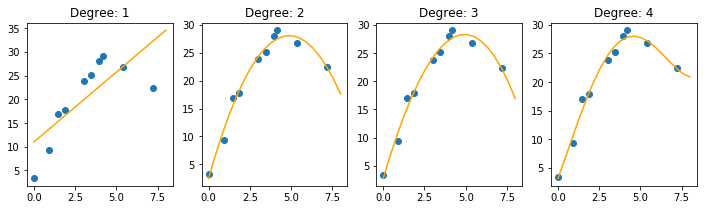

In [32]:
fig, axes = plt.subplots(1, 4, figsize = (12, 3))
degs = (1, 2, 3, 4)

for idx in range(len(degs)):
    deg = degs[idx]
    A   = get_model_matrix(x, deg)
    b, res, r, s = la.lstsq(A, y)
    
    xs   = np.linspace(0, 8, 20)
    A    = get_model_matrix(xs, deg)
    yhat = A.dot(b)
    
    ax = axes[idx]
    ax.scatter(x, y)
    ax.plot(xs, yhat, color = "orange")
    ax.set_title("Degree: " + str(deg))

# Q3.3
**Calculate the sum of squares error for each model using leave one out cross-validation.**

LOOCV function

In [21]:
def loocv(deg, x, y):
    """Perform Leave one out cross-validation"""
    ### initialization
    nrow = y.shape[0]
    y = y.reshape(-1, 1)
    A = get_model_matrix(x, deg)
    
    ### leave one out
    loss = np.empty(nrow) # initialization
    for idx in range(nrow):
        ### leave one out and fit the model
        A_oneout = leave_one_out(A, idx)
        y_oneout = leave_one_out(y, idx)
        b, res, s, r = la.lstsq(A_oneout, y_oneout)
        
        ### get yhat and calculate residual
        yhat = A @ b
        loss[idx] = np.square(y[idx] - yhat[idx])
        
    return loss.sum()

Perform LOOCV on degree 2, 3, 4

In [22]:
for deg in (2, 3, 4):
    print("Degree:", deg, "|", "LOOCV:", loocv(deg, x, y))

Degree: 2 | LOOCV: 22.221307094447297
Degree: 3 | LOOCV: 119.63521588843629
Degree: 4 | LOOCV: 510.60567208652617


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


**4** (20 points)

- Write a gradient descent algorithm to fit a cubic polynomial to the data from question 5. Use a learning rate of 1e-5 and 1 million iterations, and start with a $\beta_0 = (1,10,1,1)$
- Use a JIT decorator to create a compiled version and report the fold-change improvement in run time. Use the timeit.timeit function with argument `number=1`, and use a lambda function to pass in a function that takes 0 arguments.
- Plot the fitted curve

# Q4.1
**Write a gradient descent algorithm to fit a cubic polynomial to the data from question 5. Use a learning rate of 1e-5 and 1 million iterations, and start with a $\beta_0 = (1,10,1,1)$**

In [23]:
x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])

gradient descend for polynomial regression

In [24]:
def gd(b, x, y, deg, rate, num_iter):
    """gradient descend for polynomial regression"""
    A = np.array([x**i for i in range(deg + 1)]).T
    
    for _ in range(num_iter):
        grad = A.T @ A @ b - A.T @ y
        b = b - rate * grad #gradient(b, x, y)
    
    return b

check if the output is the same as numpy lstsq

In [25]:
b        = np.array([1, 10, 1, 1]).reshape(-1, 1)
deg      = 3
rate     = 1e-5
num_iter = 10**6

x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])
y = y.reshape(-1, 1)

gd(b, x, y, deg, rate, num_iter)

array([[ 2.75202065],
       [ 9.930932  ],
       [-0.86991684],
       [-0.01878794]])

# Q4.2
**Use a JIT decorator to create a compiled version and report the fold-change improvement in run time. Use the timeit.timeit function with argument `number=1`, and use a lambda function to pass in a function that takes 0 arguments.**

In [26]:
@jit(float64[:, :](float64[:, :], float64[:], float64[:, :], int64, float64, int64), nopython = True)
def gd_jit(b, x, y, deg, rate, num_iter):
    """gradient descend for polynomial regression"""
    n = x.shape[0]
    A = np.empty((n, deg + 1))
    for i in range(0, deg + 1):
        A[:, i] = x**i
    
    for _ in range(num_iter):
        grad = A.T @ A @ b - A.T @ y
        b = b - rate * grad
    
    return b

check if the results are the same

In [27]:
b        = np.array([1.0, 10.0, 1.0, 1.0]).reshape(-1, 1)
deg      = 3
rate     = 1e-5
num_iter = 10**6

x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])
y = y.reshape(-1, 1)

gd_jit(b, x, y, deg, rate, num_iter)

array([[ 2.75202065],
       [ 9.930932  ],
       [-0.86991684],
       [-0.01878794]])

time the functions to check the efficiency

In [28]:
b        = np.array([1.0, 10.0, 1.0, 1.0]).reshape(-1, 1)
deg      = 3
rate     = 1e-5
num_iter = 10**6

x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])
y = y.reshape(-1, 1)

t1 = timeit.timeit(lambda : gd(b, x, y, deg, rate, num_iter),     number = 1)
t2 = timeit.timeit(lambda : gd_jit(b, x, y, deg, rate, num_iter), number = 1)
print(t1)
print(t2)

5.171586957760155
1.4182594073936343


get the fold change of time improvement

In [29]:
print(t1 / t2)

3.6464323316311305


# Q4.3
**Plot the fitted curve**

get the beta using gradient descend

In [30]:
b        = np.array([1.0, 10.0, 1.0, 1.0]).reshape(-1, 1)
deg      = 3
rate     = 1e-5
num_iter = 10**6

x = np.array([4.17022005e+00, 7.20324493e+00, 1.14374817e-03, 3.02332573e+00,
       1.46755891e+00, 9.23385948e-01, 1.86260211e+00, 3.45560727e+00,
       3.96767474e+00, 5.38816734e+00])
y = np.array([29.05627699, 22.38450486,  3.33047527, 23.84338844, 16.98396787,
        9.32107716, 17.8343173 , 25.23079674, 28.068074  , 26.74943485])
y = y.reshape(-1, 1)

b = gd_jit(b, x, y, deg, rate, num_iter)

plot the curve

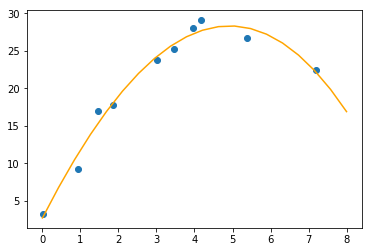

In [31]:
xs = np.linspace(0, 8, 20)
yhat = (get_model_matrix(xs, deg = 3) @ b).flatten()
plt.scatter(x, y.flatten())
plt.plot(xs, yhat, color = "orange")

Note: Lync come up with a quicker gd
```
def gd_jit(b, x, y, deg, rate, num_iter):
    """gradient descend for polynomial regression"""
    n = x.shape[0]
    A = np.empty((n, deg + 1))
    for i in range(0, deg + 1):
        A[:, i] = x**i
    
    ATA = A.T @ A
    ATY = A.T @ y
    for _ in range(num_iter):
        grad = ATA @ b - ATY
        b = b - rate * grad
    
    return b
```